In [1]:
import numpy as np
from numba import njit, prange
import csv
import os
import pandas as pd
from glob import glob
import time
import matplotlib.pyplot as plt
from src import functions as fcts
import scipy.stats as sc
import shutil
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
import math
import sys
import PIL
import random
import ripleyk
from skimage import measure
import seaborn as sns

print(sys.executable)

/Users/isabellegarnreiter/opt/anaconda3/envs/vesicleSTORM/bin/python


In [141]:
#upload csv file

storm_data = pd.read_pickle('/users/isabellegarnreiter/documents/vesicleSTORM/data/bassoon_storm_data.pkl')



In [142]:
storm_data['markertype and DIV'] = storm_data['647nm'] + storm_data['DIV']


<Axes: xlabel='volume', ylabel='point_count'>

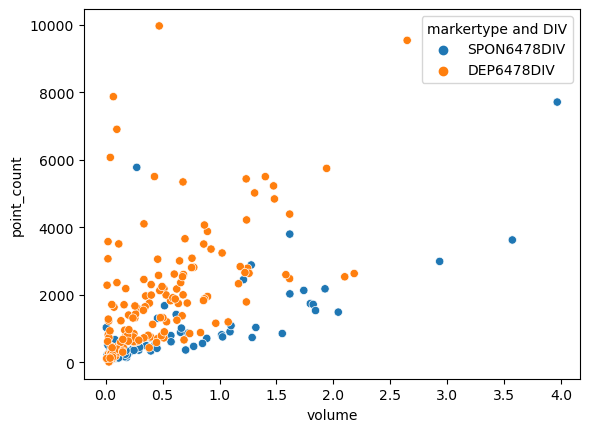

In [143]:
sns.scatterplot(data=storm_data, x = 'volume', y = 'point_count' , hue = 'markertype and DIV')
#sns.regplot(data=storm_data, x = 'volume', y = 'point_count')

Text(0, 0.5, 'Sphericity')

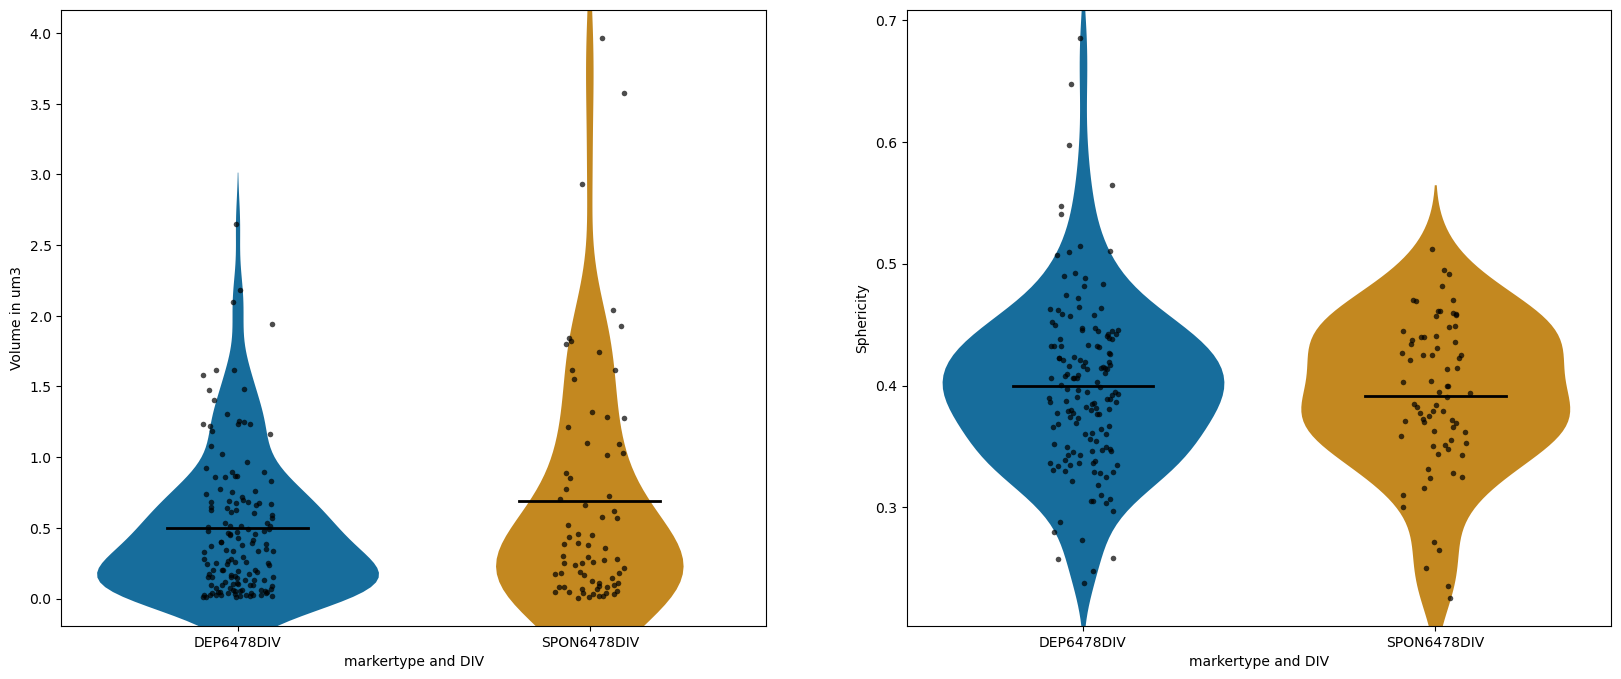

In [146]:
x = 'markertype and DIV'

storm_data['markertype and DIV'] = storm_data['647nm'] + storm_data['DIV']
conditions = ['DEP and 8DIV', 'SPON and 8DIV', 'DEP and 10DIV', 'SPON and 10DIV']

# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))


# Volume plot
sns.violinplot(data=storm_data.sort_values(by=[x]), x=x, y='volume', ax=axes[0], 
             linewidth=0, palette='colorblind')
sns.stripplot(data=storm_data.sort_values(by=[x]), x=x, y='volume', 
              ax=axes[0], jitter=True, color='black', alpha=0.7, size=4)

axes[0].set_xlim([-0.5, len(storm_data[x].unique())-0.5])
for i, group in enumerate(storm_data.groupby(x)):
    mean_val = group[1]['volume'].mean()
    axes[0].plot([i-0.2, i+0.2], [mean_val, mean_val], 'k-', lw=2)
    

# Sphericity plot
sns.violinplot(data=storm_data.sort_values(by=[x]), x=x, y='spherecity', ax=axes[1], 
               label=conditions[i], linewidth=0, palette='colorblind')
sns.stripplot(data=storm_data.sort_values(by=[x]), x=x, y='spherecity', 
              ax=axes[1], jitter=True, color = 'black', alpha=0.7, size=4)

axes[1].set_xlim([-0.5, len(storm_data[x].unique())-0.5])
for i, group in enumerate(storm_data.groupby(x)):
    mean_val = group[1]['spherecity'].mean()
    axes[1].plot([i-0.2, i+0.2], [mean_val, mean_val], 'k-', lw=2)

    
# Add titles and axis labels
axes[0].set_ylabel('Volume in um3')
axes[1].set_ylabel('Sphericity')

# Show plot

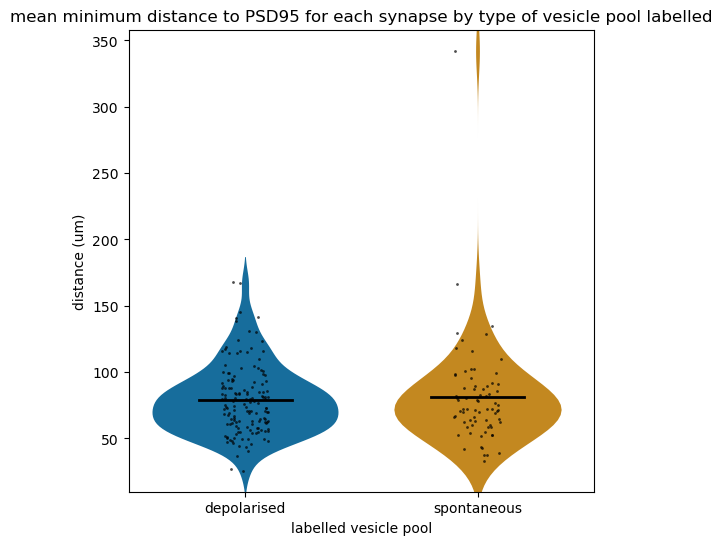

In [147]:
x = '647nm'
y = 'mean_coloc'

storm_data = storm_data[storm_data['mean_coloc'] <=1000]

ttest, pval = sc.ttest_ind(storm_data[storm_data['647nm']=='DEP647']['mean_coloc'], 
                           storm_data[storm_data['647nm']=='SPON647']['mean_coloc'])

# Set up plot
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Volume plot
sns.violinplot(data=storm_data.sort_values(by=[x]), x=x, y=y, 
             linewidth=0, palette='colorblind')
sns.stripplot(data=storm_data.sort_values(by=[x]), x=x, y=y, jitter=True, color='black', alpha=0.7, size=2)

plt.xlim([-0.5, len(storm_data[x].unique())-0.5])
plt.xlabel('labelled vesicle pool')
plt.xticks(ticks = [0,1],labels = ['depolarised', 'spontaneous'])

for i, group in enumerate(storm_data.groupby(x)):
    mean_val = group[1][y].mean()
    plt.plot([i-0.2, i+0.2], [mean_val, mean_val], 'k-', lw=2)

plt.annotate(f'p-value = {pval:6f}',
            xy=(1.4, 880),
            horizontalalignment='right', verticalalignment='top')    
    
plt.ylabel('distance (um)')
plt.title('mean minimum distance to PSD95 for each synapse by type of vesicle pool labelled')
plt.show()

In [115]:
storm_data['points']

1      [[33611.34, 5783.226, 303.991], [33658.559, 57...
2      [[40829.086, 28678.516, 346.53700000000003], [...
3      [[36424.156, 38649.547, 285.063], [36719.188, ...
4      [[32925.059, 12894.652, 214.96800000000002], [...
5      [[27286.654, 44545.809, 1131.896], [27169.309,...
                             ...                        
732    [[37396.586, 8120.258, 726.732], [37419.996, 8...
733    [[41468.816, 3632.492, 803.178], [41439.203, 3...
734    [[31098.545, 11518.293, 774.703], [31167.758, ...
735    [[20388.957, 27792.986, 422.88800000000003], [...
736    [[31931.24, 23781.66, 413.211], [31744.051, 23...
Name: points, Length: 736, dtype: object

In [148]:
storm_data['multivariate_ripleyk'] = storm_data['multivariate_ripleyk'].apply(np.array)
storm_data['univariate_ripleyk'] = storm_data['univariate_ripleyk'].apply(np.array)

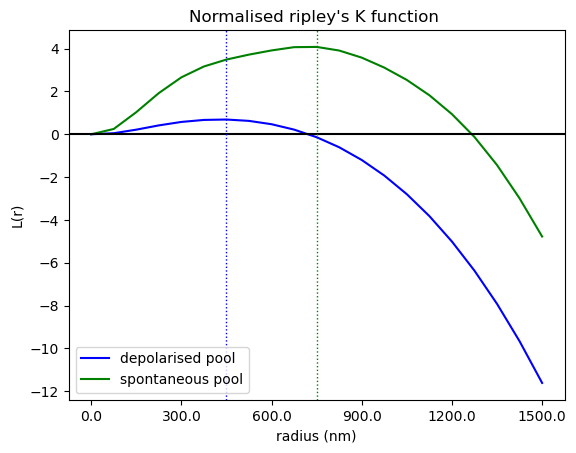

In [151]:
radii = np.linspace(0,1.5,21)

dep_ripley = storm_data[storm_data['647nm'] == 'DEP647']['univariate_ripleyk'].to_numpy()
spon_ripley = storm_data[storm_data['647nm'] == 'SPON647']['univariate_ripleyk'].to_numpy()

csr = radii*np.pi*4/3

plt.plot(np.array([np.mean(dep_ripley, axis=0), np.mean(spon_ripley, axis=0)]).T)
plt.axhline(y=0, color='black', linestyle='-')

plt.gca().get_lines()[0].set_color('blue')  # dep_ripley line color
plt.gca().get_lines()[1].set_color('green')  # spon_ripley line color


# Plot vertical dotted lines at the maxima
dep_max_idx = np.argmax(np.mean(dep_ripley, axis=0))
spon_max_idx = np.argmax(np.mean(spon_ripley, axis=0))

plt.axvline(x=dep_max_idx, color='blue', linestyle=':', linewidth=1)
plt.axvline(x=spon_max_idx, color='green', linestyle=':', linewidth=1)

plt.xticks(list(np.linspace(0,20,6)), labels=np.linspace(0,1500,6))
# Add titles and axis labels
plt.ylabel("L(r)")
plt.xlabel('radius (nm)')
plt.legend(['depolarised pool', 'spontaneous pool'])
plt.title("Normalised ripley's K function ")
plt.show()
# Show plot

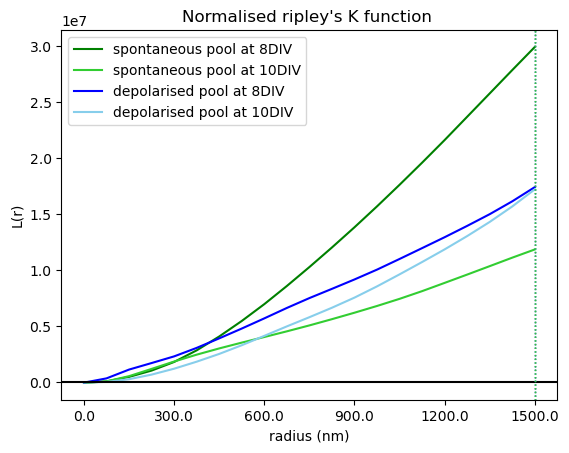

In [139]:
radii = np.linspace(0,1.5,21)

spon_8_r = storm_data[storm_data['markertype and DIV']=='SPON6478DIV']['multivariate_ripleyk'].to_numpy()
spon_10_r = storm_data[storm_data['markertype and DIV']=='SPON64710DIV']['multivariate_ripleyk'].to_numpy()
dep_8_r = storm_data[storm_data['markertype and DIV']=='DEP6478DIV']['multivariate_ripleyk'].to_numpy()
dep_10_r = storm_data[storm_data['markertype and DIV']=='DEP64710DIV']['multivariate_ripleyk'].to_numpy()

csr = radii*np.pi*4/3

plt.plot(np.array([np.mean(spon_8_r, axis=0), 
                   np.mean(spon_10_r, axis=0),
                   np.mean(dep_8_r, axis=0),
                   np.mean(dep_10_r, axis=0)]).T)
plt.axhline(y=0, color='black', linestyle='-')

plt.gca().get_lines()[0].set_color('green')  # dep_ripley line color
plt.gca().get_lines()[1].set_color('limegreen')  # dep_ripley line color
plt.gca().get_lines()[2].set_color('blue')  # spon_ripley line color
plt.gca().get_lines()[3].set_color('skyblue')  # spon_ripley line color


# Plot vertical dotted lines at the maxima
spon_8_max_idx = np.argmax(np.mean(spon_8_r, axis=0))
dep_8_max_idx = np.argmax(np.mean(dep_8_r, axis=0))
spon_10_max_idx = np.argmax(np.mean(spon_10_r, axis=0))
dep_10_max_idx = np.argmax(np.mean(dep_10_r, axis=0))


plt.axvline(x=dep_8_max_idx, color='blue', linestyle=':', linewidth=1)
plt.axvline(x=spon_8_max_idx, color='green', linestyle=':', linewidth=1)
plt.axvline(x=dep_10_max_idx, color='skyblue', linestyle=':', linewidth=1)
plt.axvline(x=spon_10_max_idx, color='limegreen', linestyle=':', linewidth=1)

plt.xticks(list(np.linspace(0,20,6)), labels=np.linspace(0,1500,6))
# Add titles and axis labels
plt.ylabel("L(r)")
plt.xlabel('radius (nm)')
plt.legend(['spontaneous pool at 8DIV', 'spontaneous pool at 10DIV', 'depolarised pool at 8DIV', 'depolarised pool at 10DIV'])
plt.title("Normalised ripley's K function ")
plt.show()
# Show plot

In [68]:
def gaussian_peak_est(data, step):
    #determine bounding box for the density estimation of points in the synapse
    data = data.T
    xmin = data[0].min()
    xmax = data[0].max()
    ymin = data[1].min()
    ymax = data[1].max()
    zmin = data[2].min()
    zmax = data[2].max()

    #get kde based on data
    kde = sc.gaussian_kde(data)

    #define the kernel size in all dimensions
    xstep = int((xmin-xmax)/step)
    ystep = int((ymin-ymax)/step)
    zstep = int((zmin-zmax)/step)

    #projec the kde onto a grid of points within the bounding box given a timestep
    X, Y, Z = np.mgrid[xmin:xmax:(xstep*1j), ymin:ymax:(ystep*1j), zmin:zmax:(zstep*1j)]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    kde_est = np.reshape(kde(positions).T, X.shape)
    
    return kde_est

storm_data['gaussian_project'] = storm_data.apply(lambda row: gaussian_peak_est(row['points'],30), axis=1)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [111]:
def get_cluster_peaks(wide_field_vesicles, params):
    
    max_threshold_ves = params['max_threshold_ves']
    min_peak_distance = params['min_peak_distance']
    
    ves_thresh = wide_field_vesicles.mean() + wide_field_vesicles.std() * max_threshold_ves
    mask_vesicles = (wide_field_vesicles > ves_thresh) * 1
    peak_coords = peak_local_max(wide_field_vesicles, min_distance=min_peak_distance)
    print(len(peak_coords))
    #if len(peak_coords)!= 0:
    #    peak_coords = np.array(fcts.filter_peaks(peak_coords, min_peak_distance))
    return peak_coords

params['min_peak_distance'] = 15

storm_data['cluster_peaks'] = storm_data.apply(lambda row: fcts.get_local_max_3d(row['gaussian_project'],(1,1,1),1), axis=1)
storm_data['number_of_peaks'] = storm_data['cluster_peaks'].apply(len)

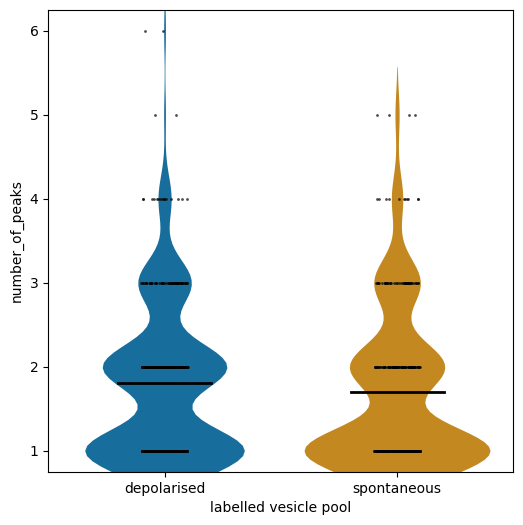

In [112]:
x = '647nm'
y = 'number_of_peaks'

ttest, pval = sc.ttest_ind(storm_data[storm_data['647nm']=='DEP647']['number_of_peaks'], 
                           storm_data[storm_data['647nm']=='SPON647']['number_of_peaks'])

# Set up plot
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Volume plot
sns.violinplot(data=storm_data.sort_values(by=[x]), x=x, y=y, 
             linewidth=0, palette='colorblind')
sns.stripplot(data=storm_data.sort_values(by=[x]), x=x, y=y, jitter=True, color='black', alpha=0.7, size=2)

plt.xlim([-0.5, len(storm_data[x].unique())-0.5])
plt.xlabel('labelled vesicle pool')
plt.xticks(ticks = [0,1],labels = ['depolarised', 'spontaneous'])

for i, group in enumerate(storm_data.groupby(x)):
    mean_val = group[1][y].mean()
    plt.plot([i-0.2, i+0.2], [mean_val, mean_val], 'k-', lw=2)

plt.annotate(f'p-value = {pval:6f}',
            xy=(1.4, 880),
            horizontalalignment='right', verticalalignment='top')    
    
plt.show()

[]


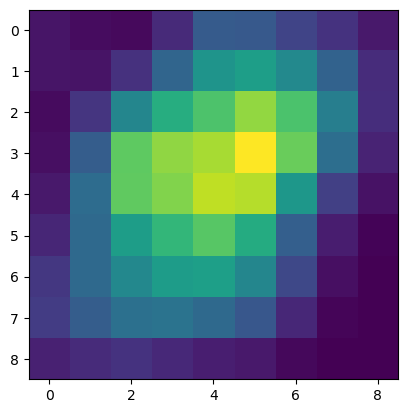

In [93]:
data = storm_data['gaussian_project'][733]
peaks = storm_data['cluster_peaks'][733]
plt.figure(1)
plt.clf()
print(peaks)
plt.imshow(data[:,:,3])
plt.plot(peaks[:, 1],peaks[:, 0],'rx')